In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
np.random.seed(1)

# Data Generation

Create our dataset. [Using sklearn](http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py) is easier: 

In [34]:
from sklearn.datasets import make_blobs

In [77]:
data, labels = make_blobs(n_features=2,\
                          centers=2,\
                          cluster_std=(0.1, 0.1), \
                          center_box=([-2,-2], [-1,1]),\
                          shuffle=True)
labels[labels==0] = -1
labels = labels[:,np.newaxis]

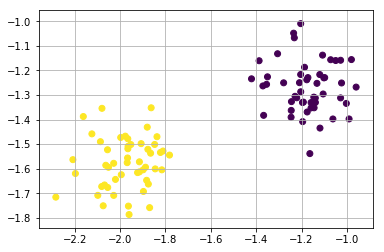

In [78]:
plt.scatter(data[:,0], data[:,1], c=labels)
plt.grid()
plt.show()

# Plotting a Seperating Plane

We will want to classify these points and plot the seperating line. This is an utility function for plotting:

In [80]:
def plotSeperatingPLane(predictionFunc, data):
    #create a meshgrid
    nb_of_xs = 100
    xs1 = np.linspace(-4, 4, num=nb_of_xs)
    xs2 = np.linspace(-4, 4, num=nb_of_xs)
    xx, yy = np.meshgrid(xs1, xs2)
    
    #classify each point in this meshgrid using a "predictionFunction"
    classification_plane = predictionFunc(np.c_[xx.ravel(), yy.ravel()])
    #reshape it to make it plottable
    classification_plane = classification_plane.reshape(xx.shape)

    #plot both the points and "contours"
    plt.contourf(xx, yy, classification_plane, cmap=plt.cm.Accent)
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.Oranges_r)
    plt.grid()

To see how the plotter works, for now let's train a logistic regression classifier using sklearn and plot the results:

In [81]:
import sklearn.linear_model
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(data, labels.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

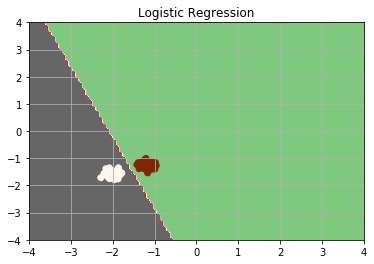

In [82]:
plotSeperatingPLane(clf.predict, data)
plt.title("Logistic Regression")

# A Single Neuron/Node

Now we are going to try to linearly separate these two clusters using a single "neuron".

<img src="SimpleANN02.png" width="15%">

Whether we use the perceptron learning rule or the delta learning rule, the main input-output relationship is given by:

$$y = f(x \cdot w^T + b) $$

where $b$ is the bias term. The $f$ function, which is called the activation, is applied to the total input going into the node. The resultant value is our prediction/classification label.

In [83]:
# create some random weights and biases
w = np.random.normal(0, 1, data.shape[1])[np.newaxis] # 1*2
b = np.random.rand()*np.ones((data.shape[0],1)) # 100*1

# the input to our node is
z = data.dot(w.T) + b

## Perceptron Learning

Perceptron activation is just a step function.
\begin{equation}
 f({z}) =\begin{cases}
    1 & \text{if } z \ge 0\\
    -1 & \text{otherwise}.
  \end{cases}
\end{equation}

Let's add this on top of the matrix multiplication/addition then wrap all in a function:

In [88]:
# our f function/activation which yields the y values
def predict(weights, biases, data):
    z = data.dot(weights.T) + biases
    return np.where(z >= 0, 1, -1)

To train our neuron, we are going to find the error cases and update the weights:

$$\Delta w = \eta \; (\text{labels} - y)\; \cdot x$$

where $\eta$ is a scalar hyperparameter called "speed" or "learning rate".

This equation tells us to "only update the weights for the wrongly classified sample points". There are two ways to implement it:
*  Stochastic training: Update the weights after each wrongly labeled sample point,
*  Batch training: Update the weights once using all of the wrongly labeled sample points.

In [86]:
# let's define the (labels - y).x part as the gradient function first
def perceptronGradient(labels, y, data):
    # A lot of tranpose operations here to match the sizes
    # (100*1).T -> 1*100
    # (1*100)*(100*2) -> 1*2 i.e. equal to w.shape()
    return ((labels - y).T.dot(data.reshape(-1,2)))

One iteration of batch training:

In [89]:
# one iteration over all the samples, called an epoch, looks like this
w = np.random.normal(0, 1, data.shape[1])[np.newaxis] # 1*2
b = np.random.rand()*np.ones((data.shape[0],1)) # 100*1
eta = 0.05
y = predict(w, b, data)
delta_w = perceptronGradient(labels, y, data)
w += eta*delta_w
b += eta*(labels - y).sum()

Let's create a Perceptron class to summarize everything up until now and also add the stochastic training version:

In [112]:
class Perceptron(object):
    
    def __init__(self, nDims, eta=0.05, epochs=10):
        self.eta = eta
        self.epochs = epochs
        self.weights = np.random.normal(0, 1, nDims)[np.newaxis] # 1*2
        self.biases = np.random.rand()
    
    # we are partitioning our above defined predict() function into
    # nodeInput() and nodeActivation() functions.
    def nodeInput(self, data):
        # this reshaping is done so that the sizes match
        # independent of the number of input samples
        data = data.reshape(-1, self.weights.shape[1])
        # the usual multiplication and bias addition
        z = data.dot(self.weights.T) + self.biases*np.ones((len(data),1)) 
        return z
    
    def nodeActivation(self, z):
        # activation for a perceptron is just a unit step function
        # i.e. positive if z>0 and negative if z<0
        return np.where(z >= 0, 1, -1)    
    
    # merge the nodeInput() and nodeActivation() functions to 
    # recreate the prediction function. This is useful for testing the neuron
    def predict(self, data):
        return self.nodeActivation(self.nodeInput(data))
    
    def train(self, data, labels):
        # here, we are going to update the weights after each epoch
        for i in range(self.epochs):
            # instead of the predict() function here we use the nodeActivation()'s
            # output. For this case they are equivalent but when we use other 
            # training rules, this distinction will be important
            y = self.nodeActivation(self.nodeInput(data))
            delta_w = (labels - y).T.dot(data.reshape(-1,2))
            self.weights += self.eta*delta_w
            self.biases += self.eta*(labels - y).sum()
        
        return self    
    
    def trainMiniBatch(self, data, labels, miniBatchSize = 1):
        # here, we are going to update the weights after each minibatch
        for i in range(self.epochs):
            # for each epoch create the minibatches
            dataMiniBatches, labelMiniBatches = self.getMiniBatch(data, labels, miniBatchSize) 
            
            # loop through all the minibatches
            for dataMiniBatch, labelMiniBatch in zip(dataMiniBatches, labelMiniBatches):
                # and for each minibatch, train the neuron as usual
                self.train(dataMiniBatch, labelMiniBatch)
                
        return self
    
    def getMiniBatch(self, data, labels, miniBatchSize):
        # create a random permutation of data abd labels
        idx = np.random.permutation(len(data))
        data,labels = data[idx], labels[idx]
        
        # create a list of mini data batches of size batchSize
        dataMiniBatches = [data[k:k+miniBatchSize] \
                           for k in range(0, len(data), miniBatchSize)]
        # create a list of mini label batches of size batchSize
        labelMiniBatches = [labels[k:k+miniBatchSize] \
                            for k in range(0, len(labels), miniBatchSize)]
        
        return dataMiniBatches, labelMiniBatches    

In [258]:
nn = Perceptron(nDims=2, epochs=30)

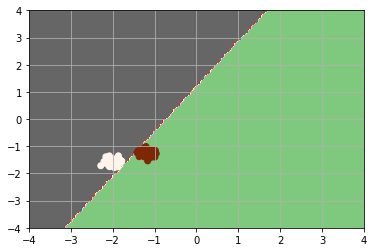

In [261]:
nn.trainMiniBatch(data,labels)
plotSeperatingPLane(nn.predict, data)

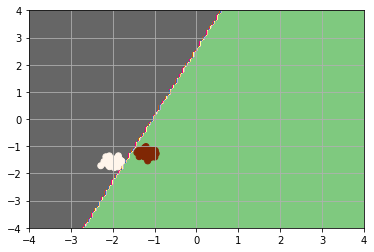

In [132]:
nn = Perceptron(nDims=2, epochs=30)
nn.train(data,labels)
plotSeperatingPLane(nn.predict, data)

In [140]:
class DeltaNeuron(object):
    
    def __init__(self, nDims, eta=0.005, epochs=10):
        self.eta = eta
        self.epochs = epochs
        self.weights = np.random.normal(0, 1, nDims)[np.newaxis] # 1*2
        self.biases = np.random.rand()
    
    # same as the perceptron
    def nodeInput(self, data):
        # this reshaping is done so that the sizes match
        # independent of the number of input samples
        data = data.reshape(-1, self.weights.shape[1])
        # the usual multiplication and bias addition
        z = data.dot(self.weights.T) + self.biases*np.ones((len(data),1)) 
        return z
    
    def nodeActivation(self, z):
        # activation for our delta neuron is just the input value itself
        return z        
    
    # We still need to get some label predictions using the activation results
    # and the obvious choice again is the unit step function
    def predict(self, data):
        y = self.nodeActivation(self.nodeInput(data))
        return np.where(y >= 0, 1, -1)
    
    def train(self, data, labels):
        # here, we are going to update the weights after each epoch
        for i in range(self.epochs):
            # instead of the predict() function here we use the nodeActivation()'s
            # output. For this case they are equivalent but when we use other 
            # training rules, this distinction will be important
            y = self.nodeActivation(self.nodeInput(data))
            delta_w = (labels - y).T.dot(data.reshape(-1,2))
            self.weights += self.eta*delta_w
            self.biases += self.eta*(labels - y).sum()
        
        return self    
    
    def trainMiniBatch(self, data, labels, miniBatchSize = 1):
        # here, we are going to update the weights after each minibatch
        for i in range(self.epochs):
            # for each epoch create the minibatches
            dataMiniBatches, labelMiniBatches = self.getMiniBatch(data, labels, miniBatchSize) 
            
            # loop through all the minibatches
            for dataMiniBatch, labelMiniBatch in zip(dataMiniBatches, labelMiniBatches):
                # and for each minibatch, train the neuron as usual
                self.train(dataMiniBatch, labelMiniBatch)
                
        return self
    
    def getMiniBatch(self, data, labels, miniBatchSize):
        # create a random permutation of data abd labels
        idx = np.random.permutation(len(data))
        data,labels = data[idx], labels[idx]
        
        # create a list of mini data batches of size batchSize
        dataMiniBatches = [data[k:k+miniBatchSize] \
                           for k in range(0, len(data), miniBatchSize)]
        # create a list of mini label batches of size batchSize
        labelMiniBatches = [labels[k:k+miniBatchSize] \
                            for k in range(0, len(labels), miniBatchSize)]
        
        return dataMiniBatches, labelMiniBatches

# A Simple Network

We are going to create a simple NN, and apply the backpropagation algorithm to train it.
<img src="nn-3-layer-network.png" width="40%">

Each node has inputs calculated by the weighted sum of the previous layer (let's call it $z$). The nodes then apply some non-linear function to their inputs, i.e. the activation function. The sigmoid is a popular activation since its derivative is easy to compute:

\begin{align}
\sigma(z) & = \frac{1}{1+e^{-z}}\\
 \sigma'(z) & = \sigma(z)(1 - \sigma(z))
\end{align}

#### Slight detour - Evaluating a function with TF

Tensorflow is kind of a pain to use, but let's try to evaluate and plot the sigmoids to show basic usage:

In [ ]:
#sigmoid implementation
def sigma(x):
    #everything is a "tensor", even the constants
    return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
#derivative of the sigmoid implementation
def dSigma(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

In [ ]:
#placeholders for input and output variables
y = tf.placeholder(tf.float32, [None,1])
x = tf.placeholder(tf.float32, [None,1])

#our input-output relation is just a sigmoid
y = sigma(x)

#create some input values as a numpy array
input_series = np.linspace(-10,10,200)[:,np.newaxis]

#evaluations are run in a tf session
sess= tf.Session()
#put the input array into the x placeholder and evaluate y
output = sess.run(y, feed_dict={x: input_series})

plt.plot(input_series, output)

## Notation

Outputs of the nodes are denoted as $a$ (for activation). 
* $a_0$ vector, the network input
* $a_1$ vector, the outputs (after applying the activation function) of the nodes in the hidden layer
* $a_2$ vector, the outputs (after applying the activation function) of the nodes in the output layer

$w_1$ is the weights vector **entering** the hidden layer, $w_2$ is the weight vector **entering** the output layer. Similarly for the $b$ bias terms.


## Forward Pass

What is the output of a network given an input?


\begin{align}
& z_1 = a_0 \cdot w_1 + b_1 \\
& a_1 = \sigma(z_1) \\
& z_2 = a_1 \cdot w_2 + b_2\\
& a_2 = \sigma(z_2) \\
\end{align}

These equations are called the **forward pass**. Note that we could include the $b$ bias terms in the dot products by appending a $1$ vector to the $a$ matrices. However I could not find a way to do this in tf if we do not want a constant input size.

In [ ]:
dataDim = 2
nClasses = 2
hiddenLayerSize = 3

#input tensor
a_0 = tf.placeholder(tf.float32, [None, dataDim])
#output tensor
y = tf.placeholder(tf.float32, [None, nClasses])

#weights and biases
w_1 = tf.Variable(tf.truncated_normal([dataDim, hiddenLayerSize]))
b_1 = tf.Variable(tf.truncated_normal([1, hiddenLayerSize]))
w_2 = tf.Variable(tf.truncated_normal([hiddenLayerSize, nClasses]))
b_2 = tf.Variable(tf.truncated_normal([1, nClasses]))

#the forward pass
z_1 = tf.add(tf.matmul(a_0, w_1), b_1) #inputs*hiddenLayerSize
a_1 = sigma(z_1) #inputs*hiddenLayerSize
z_2 = tf.add(tf.matmul(a_1, w_2), b_2) #inputs*nClasses
a_2 = sigma(z_2) #inputs*nClasses

## Backward Pass

For a 2 layer network, the [BP1](http://neuralnetworksanddeeplearning.com/chap2.html#eqtnBP1), [BP2](http://neuralnetworksanddeeplearning.com/chap2.html#eqtnBP2), [BP3](http://neuralnetworksanddeeplearning.com/chap2.html#eqtnBP3) & [BP4](http://neuralnetworksanddeeplearning.com/chap2.html#eqtnBP4)  equations from chapter 2 of Michael Nielsen's book becomes:

\begin{align}
\delta_2 &= \nabla_{a} C \odot \sigma'(z_2) \\
\nabla_{b_2} C &= \delta_2\\
\nabla w_2 &= a_1^T \cdot \delta_2 \\
\\
\delta_1 &= (\delta_2 \cdot w_2^T) \odot \sigma'(z_1) \\
\nabla_{b_1} C &= \delta_1 \\
\nabla w_1 &= a_0^T \cdot \delta_1 \\
\end{align}

where,
\begin{align}
\nabla_{a} C = a_2 - y
\end{align}

This gradient of the cost function wrt the output of the final layer is in our case just the "error".

In [ ]:
cost_gradient = tf.subtract(a_2, y) #inputs*nClasses

delta_2 = tf.multiply(cost_gradient, dSigma(z_2)) #inputs*nClasses
grad_b_2 = delta_2
grad_w_2 = tf.matmul(tf.transpose(a_1), delta_2) #hiddenLayerSize*nClasses

delta_1 = tf.multiply(tf.matmul(delta_2, tf.transpose(w_2)) \
                      , dSigma(z_1)) #inputs*hiddenLayerSize
grad_b_1 = delta_1 #inputs*hiddenLayerSize
grad_w_1 = tf.matmul(tf.transpose(a_0), delta_1) #dataDim*hiddenLayerSize

In [ ]:
eta = tf.constant(0.05)
step = [
    tf.assign(w_1,
            tf.subtract(w_1, tf.multiply(eta, grad_w_1)))
  , tf.assign(b_1,
            tf.subtract(b_1, tf.multiply(eta,
                               tf.reduce_mean(grad_b_1, axis=[0]))))
  , tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta, grad_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.reduce_mean(grad_b_2, axis=[0]))))
]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc_labels = enc.fit_transform(labels[:,np.newaxis])

In [ ]:
def nnpredictor(data):
    return np.argmax(sess.run(a_2, feed_dict = {a_0: data}),axis=1)

In [ ]:
acct_mat = tf.equal(tf.argmax(a_2, 1), tf.argmax(y, 1))
acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(20):
    sess.run(step, feed_dict = {a_0: data,
                            y : enc_labels})
plotSeperatingPLane(nnpredictor, data)
plt.title("NN")